# Motorcyle parts sales analysis

In this notebook, we will analyze the sales of the company across three warehouses in the metropolitan area. Besides answering the competition questions, we will apply a clustering algorithm that will cluster some columns per sales so we could understand how our cutomers behave, and which warehouses are bringing more sales.

Colleague's questions.

1. What are the total sales for each payment method?
2. What is the average unit price for each product line?
3. Further investigation (e.g., average purchase value by client type, total purchase value by product line, etc.)
5. Summary.

Following list is the plan of our notebook:

## Plan
1. Data Analysis.
2. Data Visualization.
3. Clustering.
4. Conclusions.

We will start by importing important libraries that I will use in the first two parts.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

Let us take a look at our data:

In [3]:
df = pd.read_csv('data/sales_data.csv', parse_dates=['date'])
df.head()

,date,warehouse,client_type,product_line,quantity,unit_price,total,payment
0,2021-06-01,Central,Retail,Miscellaneous,8,16.85,134.83,Credit card
1,2021-06-01,North,Retail,Breaking system,9,19.29,173.61,Cash
2,2021-06-01,North,Retail,Suspension & traction,8,32.93,263.45,Credit card
3,2021-06-01,North,Wholesale,Frame & body,16,37.84,605.44,Transfer
4,2021-06-01,Central,Retail,Engine,2,60.48,120.96,Credit card


# Data Analysis

## Sales per warehouse:

In [4]:
df.groupby('warehouse')[['total']].sum()

,total
warehouse,
Central,141982.88
North,100203.63
West,46926.49


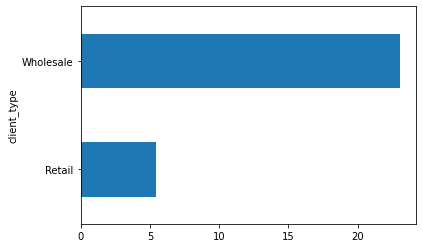

In [5]:
avg_units_client_type = df.groupby('client_type')['quantity'].mean()
avg_units_client_type.plot(kind='barh')
plt.show()

## What are the total sales for each payment method?

In [6]:
df.groupby('payment')[['total']].sum().reset_index()

,payment,total
0,Cash,19199.10
1,Credit card,110271.57
2,Transfer,159642.33


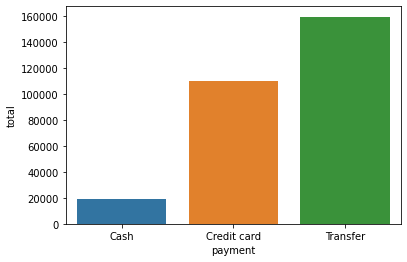

In [7]:
sns.barplot(x='payment', y='total', data=df.groupby('payment')[['total']].sum().reset_index())
plt.show()

## What is the average unit price for each product line?

In [8]:
df.groupby('product_line')[['unit_price']].agg(np.mean).reset_index()

,product_line,unit_price
0,Breaking system,17.740522
1,Electrical system,25.585130
2,Engine,60.091803
3,Frame & body,42.832229
4,Miscellaneous,22.810738
5,Suspension & traction,33.969868


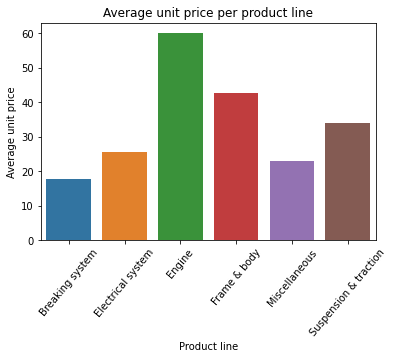

In [9]:
sns.barplot(x="product_line", y="unit_price", data=df.groupby('product_line')[['unit_price']].agg(np.mean).reset_index())
plt.xticks(rotation=50)
plt.xlabel("Product line")
plt.ylabel("Average unit price")
plt.title("Average unit price per product line")
plt.show()

## Further investigation (e.g., average purchase value by client type, total purchase value by product line, etc.)

In [10]:
df.groupby('client_type')[['total']].agg(np.mean)

,total
client_type,
Retail,167.058929
Wholesale,709.521467


In [11]:
df.groupby('product_line')[['total']].agg(np.mean)

,total
product_line,
Breaking system,166.739783
Electrical system,225.972591
Engine,622.055410
Frame & body,415.811627
Miscellaneous,222.670656
Suspension & traction,320.237763


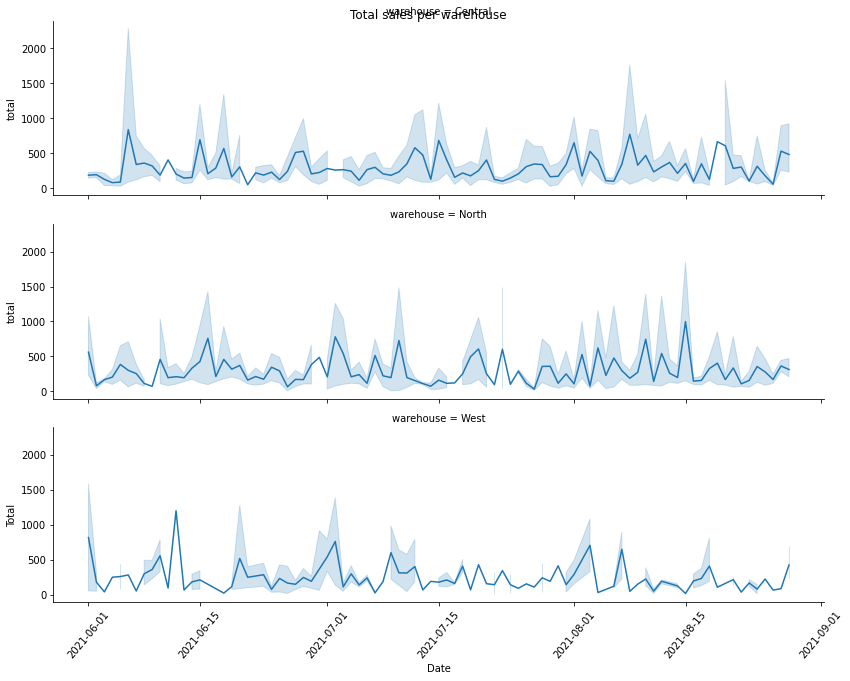

In [93]:
g = sns.FacetGrid(df, row="warehouse", height=3, aspect=4,)
g.map(sns.lineplot, "date", "total")
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Total")

plt.suptitle("Total sales per warehouse")
plt.show()

In [103]:
df.groupby('warehouse')['total'].std()

warehouse
Central    366.398590
North      348.252613
West       274.287941
Name: total, dtype: float64

# Clustering:

As a first step, I will use manifold clustering on our dataset.

`Manifold clustering, which regards clusters as groups of points around compact manifolds, has been realized as a promising generalization of traditional clustering. A number of linear or nonlinear manifold clustering approaches have been developedrecently.` https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/pricai10.pdf

The main application of manifold learning techniques is to explore and visualize hidden patterns in high-dimension data by reducing dimensions of data. These hidden patterns are analyzed better in low-dimension spaces.

First, I will use LabelEncoder function to treat categorical data.

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
df.head()

,date,warehouse,client_type,product_line,quantity,unit_price,total,payment
0,2021-06-01,Central,Retail,Miscellaneous,8,16.85,134.83,Credit card
1,2021-06-01,North,Retail,Breaking system,9,19.29,173.61,Cash
2,2021-06-01,North,Retail,Suspension & traction,8,32.93,263.45,Credit card
3,2021-06-01,North,Wholesale,Frame & body,16,37.84,605.44,Transfer
4,2021-06-01,Central,Retail,Engine,2,60.48,120.96,Credit card


In [15]:
X = df[['warehouse', 'client_type', 'product_line', 'total', 'payment']]

In [16]:
label_encoder = LabelEncoder()
X["warehouse"] = label_encoder.fit_transform(X["warehouse"])
X["client_type"] = label_encoder.fit_transform(X["client_type"])
X["product_line"] = label_encoder.fit_transform(X["product_line"])
X["payment"] = label_encoder.fit_transform(X["payment"])

Before using Manifold (MDS of slearn), it is important to standarize data on a common scale, for this I will use StandardScaler of sklearn.

In [17]:
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler

X_norm = StandardScaler().fit(X).transform(X)  

mds = MDS(n_components = 2)

X_mds = mds.fit_transform(X_norm)

We can see that mds reduced dimension of our data to 2, while keeping the same number of observations.

In [72]:
X_mds.shape

(1000, 2)

Now we have two features, it is easier to visualize our data now.

Using hue function of scatterplot we can easily visualize these dimensions in term of our columns. lets write a helper function for this matter.

In [73]:
def scatter_cust(hue):
    sns.scatterplot(y=X_mds[:,0], x=X_mds[:,1], hue = df[hue])
    plt.show()

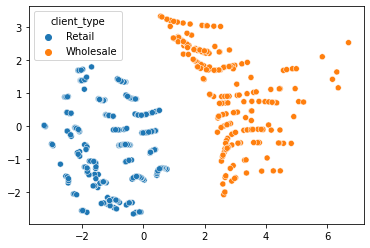

In [74]:
scatter_cust('client_type')

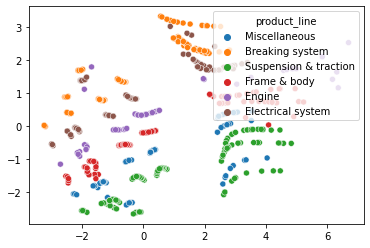

In [75]:
scatter_cust('product_line')

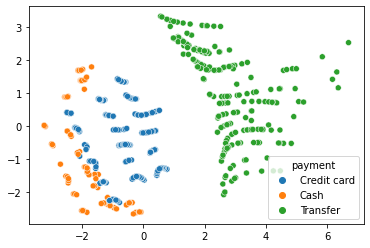

In [76]:
scatter_cust('payment')

It is kind of clear that we can distinguish two clusters from our data, but to make sure, I will use the elbow method.

In [25]:
from sklearn.cluster import KMeans

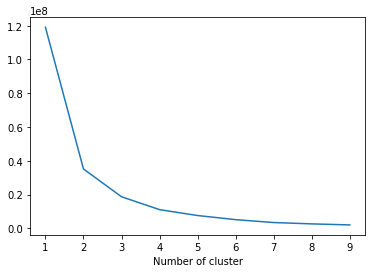

In [87]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    X["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
    

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))

plt.xlabel("Number of cluster")
plt.show()

From this plot, we can conclude that we have two clusters in our data.

In [89]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
res = kmeans.predict(X)
X['cluster_kmeans'] = kmeans.labels_
X.head()

,warehouse,client_type,product_line,total,payment,clusters,cluster,cluster_kmeans
0,0,0,4,134.83,1,1,0,0
1,1,0,0,173.61,0,1,0,0
2,1,0,5,263.45,1,6,0,0
3,1,1,3,605.44,2,0,0,0
4,0,0,2,120.96,1,1,0,0


In [90]:
def cust_swarm(row, x, y):
    g = sns.FacetGrid(X, row=row, height=4, aspect=4,)
    g.map(sns.swarmplot, x, y)
    plt.xticks(rotation=50)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

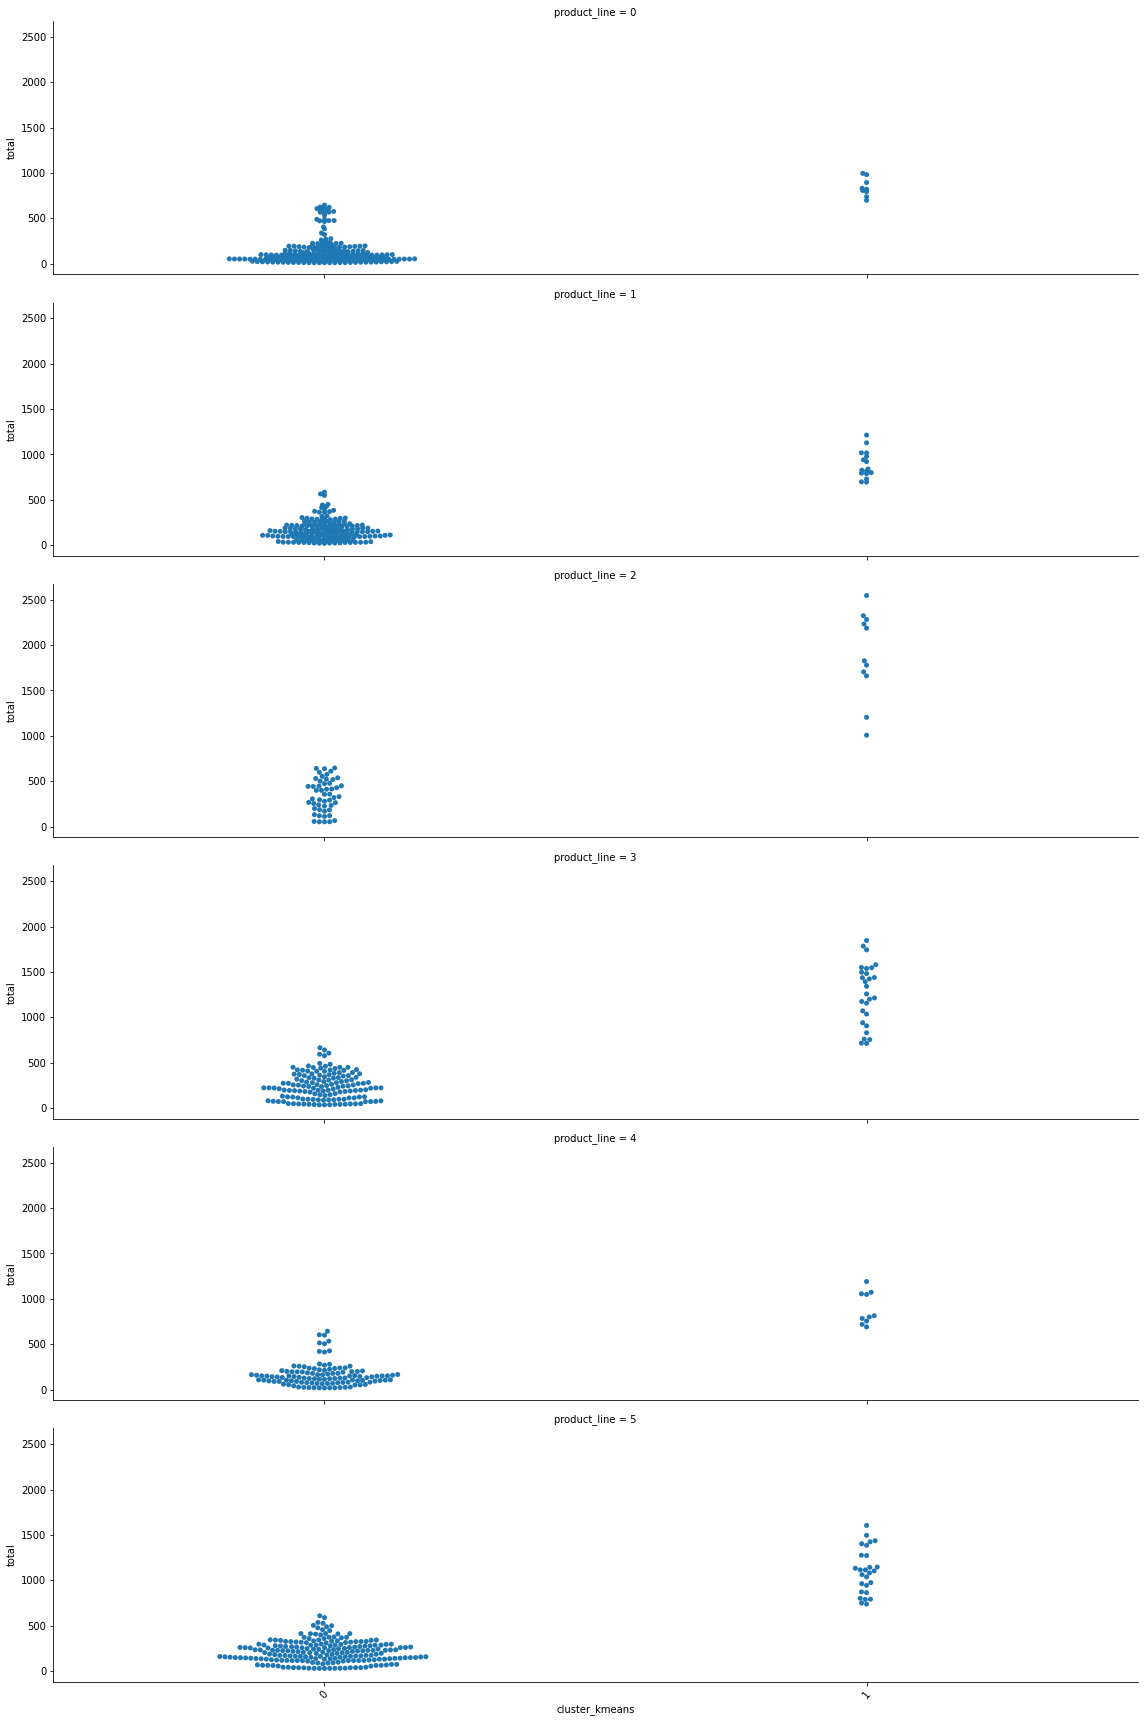

In [91]:
cust_swarm('product_line', 'cluster_kmeans', 'total')

# Conclusions

What are the total sales for each payment method?
What is the average unit price for each product line?
Further investigation (e.g., average purchase value by client type, total purchase value by product line, etc.)
Summary.

From our analysis, we can make many conclusions, some of them are: <br>
    -> Central and North warehouses made more sales than West warehouse by a big margin.<br>
    -> We made more sales using transfer and credit card than cash.<br>
    -> The data could be divided to two clusters.<br>
    -> We made more sales with wholesale clients. <br>
    -> We made the highest number of sales in the engine product line. <br>
    -> Standard deviation in north and central warehouses is higher than west warehouse, which might indicate that we have more repeating customers in central warehouse.

`Omar El Yousfi`